In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'GBPUSD'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,slope_3,slope_4,slope_5,slope_10,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
29,11/2/2000,1.6087,1.6104,1.5879,1.5927,0.0,-220.541232,-148.374761,116.575200,-107.755377,...,-3.167558,-3.694522,-3.267537,1.614067,-0.008967,-86.662888,1.61380,1.59660,1.605200,1.59915
30,14/2/2000,1.5927,1.5971,1.5860,1.5873,0.0,-96.150780,-124.492058,-143.325143,-106.453867,...,-3.213415,-3.495866,-4.021042,1.610986,-0.009996,-110.447349,1.60375,1.58695,1.595350,1.59155
31,15/2/2000,1.5873,1.5976,1.5851,1.5960,1.0,-112.616576,-122.682684,-147.339957,-117.987932,...,-2.629492,-2.682927,-2.966926,1.608822,-0.010231,-89.798011,1.59735,1.58555,1.591450,1.59135
32,16/2/2000,1.5960,1.6100,1.5946,1.6072,1.0,120.778978,-2.117010,-87.880276,-35.636482,...,-0.973506,-1.946190,-2.000000,1.608313,-0.009664,-20.623657,1.60380,1.58985,1.596825,1.60230
33,17/2/2000,1.6072,1.6138,1.6027,1.6083,1.0,112.855285,142.663121,80.169944,27.926070,...,-0.458006,-0.905730,-1.879080,1.608309,-0.009055,23.711340,1.61190,1.59865,1.605275,1.60825


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)

In [7]:
df.head()

,date,high,open,low,close,slope_3,slope_4,slope_5,slope_10,slope_20,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
29,11/2/2000,1.6104,1.6087,1.5879,1.5927,-220.541232,-148.374761,116.575200,-107.755377,-251.128297,...,-3.167558,-3.694522,-3.267537,1.614067,-0.008967,-86.662888,1.61380,1.59660,1.605200,1.59915
30,14/2/2000,1.5971,1.5927,1.5860,1.5873,-96.150780,-124.492058,-143.325143,-106.453867,-249.893985,...,-3.213415,-3.495866,-4.021042,1.610986,-0.009996,-110.447349,1.60375,1.58695,1.595350,1.59155
31,15/2/2000,1.5976,1.5873,1.5851,1.5960,-112.616576,-122.682684,-147.339957,-117.987932,-248.908844,...,-2.629492,-2.682927,-2.966926,1.608822,-0.010231,-89.798011,1.59735,1.58555,1.591450,1.59135
32,16/2/2000,1.6100,1.5960,1.5946,1.6072,120.778978,-2.117010,-87.880276,-35.636482,-248.159165,...,-0.973506,-1.946190,-2.000000,1.608313,-0.009664,-20.623657,1.60380,1.58985,1.596825,1.60230
33,17/2/2000,1.6138,1.6072,1.6027,1.6083,112.855285,142.663121,80.169944,27.926070,-250.532839,...,-0.458006,-0.905730,-1.879080,1.608309,-0.009055,23.711340,1.61190,1.59865,1.605275,1.60825


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 10% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.44281622, 0.44759583, 0.44222977, ..., 0.44447556, 0.44459004,
        0.43930315],
       [0.42816219, 0.42986927, 0.44014894, ..., 0.43366747, 0.43360562,
        0.43086995],
       [0.42871309, 0.42388655, 0.43916329, ..., 0.43209946, 0.42925646,
        0.43064802],
       ...,
       [0.11293521, 0.10791048, 0.12452086, ..., 0.11048888, 0.10725139,
        0.11223924],
       [0.12395328, 0.11588744, 0.13612967, ..., 0.11575293, 0.1148903 ,
        0.12366844],
       [0.12450419, 0.12940394, 0.12506845, ..., 0.11603293, 0.11795701,
        0.11834221]])

In [10]:
input_data.shape

(5212, 33)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [12]:
input_data

array([[0.44281622, 0.44759583, 0.44222977, ..., 0.44447556, 0.44459004,
        0.43930315],
       [0.42816219, 0.42986927, 0.44014894, ..., 0.43366747, 0.43360562,
        0.43086995],
       [0.42871309, 0.42388655, 0.43916329, ..., 0.43209946, 0.42925646,
        0.43064802],
       ...,
       [0.11293521, 0.10791048, 0.12452086, ..., 0.11048888, 0.10725139,
        0.11223924],
       [0.12395328, 0.11588744, 0.13612967, ..., 0.11575293, 0.1148903 ,
        0.12366844],
       [0.12450419, 0.12940394, 0.12506845, ..., 0.11603293, 0.11795701,
        0.11834221]])

In [13]:
input_data[[0],1:]

array([[0.44759583, 0.44222977, 0.42986927, 0.40336672, 0.56008307,
        0.61788904, 0.56293394, 0.43063256, 0.30418085, 0.43448849,
        0.34793734, 0.3515838 , 0.35583121, 0.41457158, 0.41260087,
        0.38039569, 0.43195315, 0.43195315, 0.41457158, 0.41260087,
        0.38039569, 0.44437551, 0.42939113, 0.38444778, 0.407909  ,
        0.46295867, 0.52271439, 0.33917658, 0.44676144, 0.44447556,
        0.44459004, 0.43930315]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.44759583, 0.44222977, 0.42986927, ..., 0.44447556,
          0.44459004, 0.43930315]],

        [[0.42986927, 0.44014894, 0.42388655, ..., 0.43366747,
          0.43360562, 0.43086995]],

        [[0.42388655, 0.43916329, 0.43352537, ..., 0.43209946,
          0.42925646, 0.43064802]],

        ...,

        [[0.41635276, 0.42788304, 0.41236428, ..., 0.42297138,
          0.4192757 , 0.41749889]],

        [[0.41236428, 0.42952579, 0.41856858, ..., 0.42089937,
          0.41609747, 0.41783178]],

        [[0.41856858, 0.43138758, 0.41557722, ..., 0.42269138,
          0.41654353, 0.4183866 ]]],


       [[[0.42986927, 0.44014894, 0.42388655, ..., 0.43366747,
          0.43360562, 0.43086995]],

        [[0.42388655, 0.43916329, 0.43352537, ..., 0.43209946,
          0.42925646, 0.43064802]],

        [[0.43352537, 0.44956741, 0.44593397, ..., 0.4369155 ,
          0.43525049, 0.44279849]],

        ...,

        [[0.41236428, 0.42952579, 0.41856858, ..., 0.42089937,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4646, 50, 32)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,231
Trainable params: 22,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4646/4646 [==============================] - 8s 2ms/step - loss: 0.0045
Epoch 2/5
4646/4646 [==============================] - 7s 1ms/step - loss: 4.2834e-04
Epoch 3/5
4646/4646 [==============================] - 7s 2ms/step - loss: 3.534

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([1.3924, 1.4017, 1.4104, 1.4145, 1.405 , 1.4025, 1.4009, 1.3989,
       1.4005, 1.407 , 1.3997, 1.3916, 1.3785, 1.3817, 1.3877, 1.393 ,
       1.3912, 1.391 , 1.3889, 1.3918, 1.3994, 1.3996, 1.3989, 1.398 ,
       1.4088, 1.4067, 1.4151, 1.4219, 1.4172, 1.4245, 1.4244, 1.42  ,
       1.4096, 1.406 , 1.4078, 1.4089, 1.4097, 1.4097, 1.4105, 1.4164,
       1.4188, 1.4223, 1.4247, 1.4297, 1.4344, 1.4377, 1.4315, 1.4246,
       1.4091, 1.4031, 1.3987, 1.3997, 1.3998, 1.3935, 1.3804, 1.3773,
       1.3666, 1.363 , 1.3586, 1.3575, 1.3593, 1.3607, 1.3618, 1.3596,
       1.3608, 1.3572, 1.3521, 1.3569, 1.3528, 1.3493, 1.3492, 1.3443,
       1.3422, 1.3389, 1.3341, 1.3325, 1.3307, 1.3348, 1.3362, 1.3399,
       1.3409, 1.3443, 1.3472, 1.3439, 1.3441, 1.3425, 1.339 , 1.3447,
       1.3298, 1.3291, 1.3273, 1.3216, 1.327 , 1.3315, 1.329 , 1.3292,
       1.3234, 1.3121, 1.3214, 1.3209, 1.3207, 1.325 , 1.3275, 1.329 ,
       1.3363, 1.3301, 1.3285, 1.3245, 1.3239, 1.3293, 1.3269, 1.312 ,
      

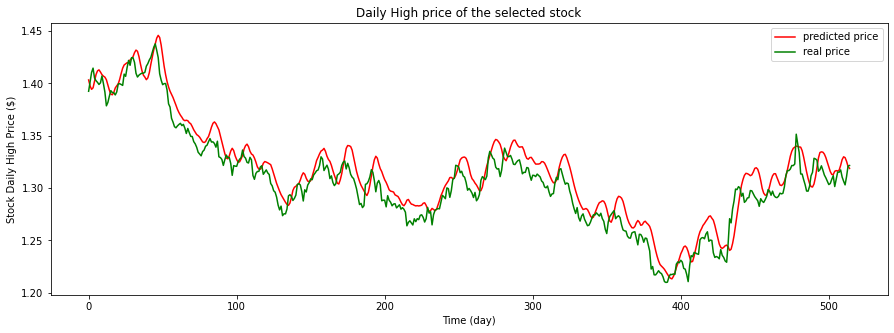

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,1.3924,1.403200,NaN,NaN
1,1.4017,1.397446,1.403200,-0.005754
2,1.4104,1.394255,1.397446,-0.003191
3,1.4145,1.395675,1.394255,0.001421
4,1.4050,1.402051,1.395675,0.006375
...,...,...,...,...
510,1.3065,1.329808,1.327105,0.002704
511,1.3030,1.329028,1.329808,-0.000780
512,1.3110,1.325454,1.329028,-0.003574
513,1.3210,1.320622,1.325454,-0.004832


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,1.3924,1.403200,NaN,NaN,NaN,1.388625,NaN
1,1.4017,1.397446,1.403200,-0.005754,-0.820981,1.395375,0.004861
2,1.4104,1.394255,1.397446,-0.003191,-0.452492,1.407425,0.008636
3,1.4145,1.395675,1.394255,0.001421,0.200871,1.404800,-0.001865
4,1.4050,1.402051,1.395675,0.006375,0.907489,1.400225,-0.003257
5,1.4025,1.408394,1.402051,0.006343,0.904528,1.398725,-0.001071
6,1.4009,1.411905,1.408394,0.003511,0.501261,1.393750,-0.003557
7,1.3989,1.412861,1.411905,0.000956,0.136732,1.393950,0.000143
8,1.4005,1.410778,1.412861,-0.002083,-0.297455,1.396450,0.001793
9,1.4070,1.408335,1.410778,-0.002443,-0.347277,1.398350,0.001361


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

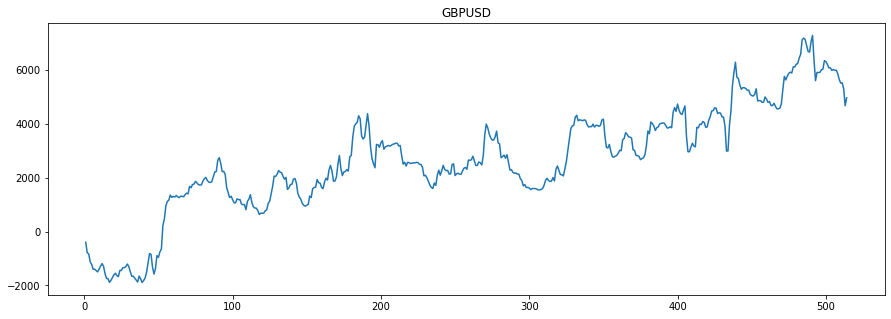

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.title(currency_name)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

0.6625588999387033

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

1.048

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 2831.860466794467 , from day 191 , to day 306
